In [65]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [66]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [67]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [34]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [35]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [36]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
columns2 = inspector.get_columns('Station')
for c in columns2:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [37]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [64]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent


('2017-08-23',)

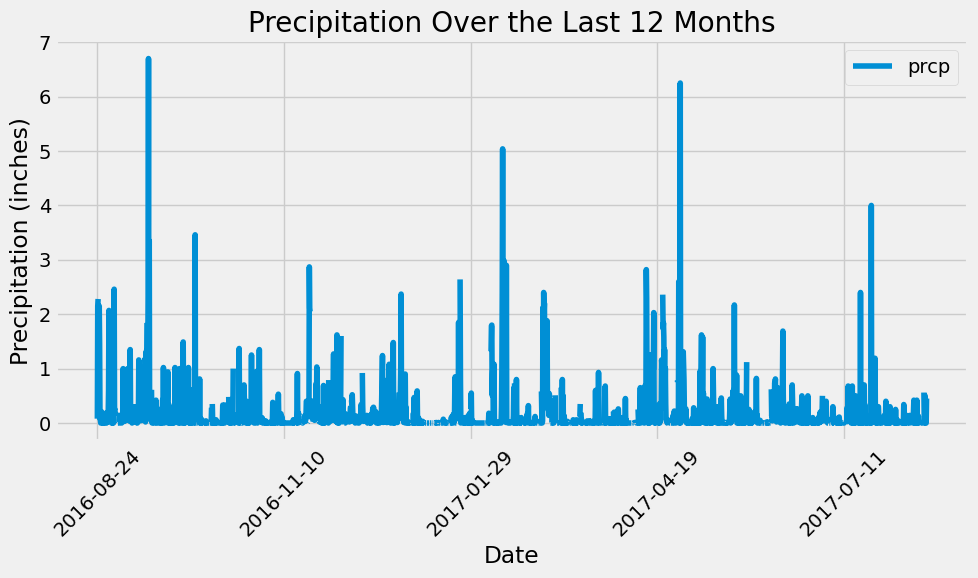

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent[0], "%Y-%m-%d")
one_year_ago = most_recent_date - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
precipitation_df.sort_values("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Plotting the data
precipitation_df.set_index("date", inplace=True)
precipitation_df.plot(figsize=(10, 6), rot=45)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.tight_layout()
plt.show()

In [70]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df.describe()
precipitation_summary

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [72]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [73]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label('count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = active_stations[0][0]

temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label("lowest_temp"),
        func.max(Measurement.tobs).label("highest_temp"),
        func.avg(Measurement.tobs).label("average_temp")
    )
    .filter(Measurement.station == most_active_station)
    .all()
)

# Display the results
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

print(f"Temperature statistics for the most active station (ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {average_temp:.2f} °F")

Temperature statistics for the most active station (ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


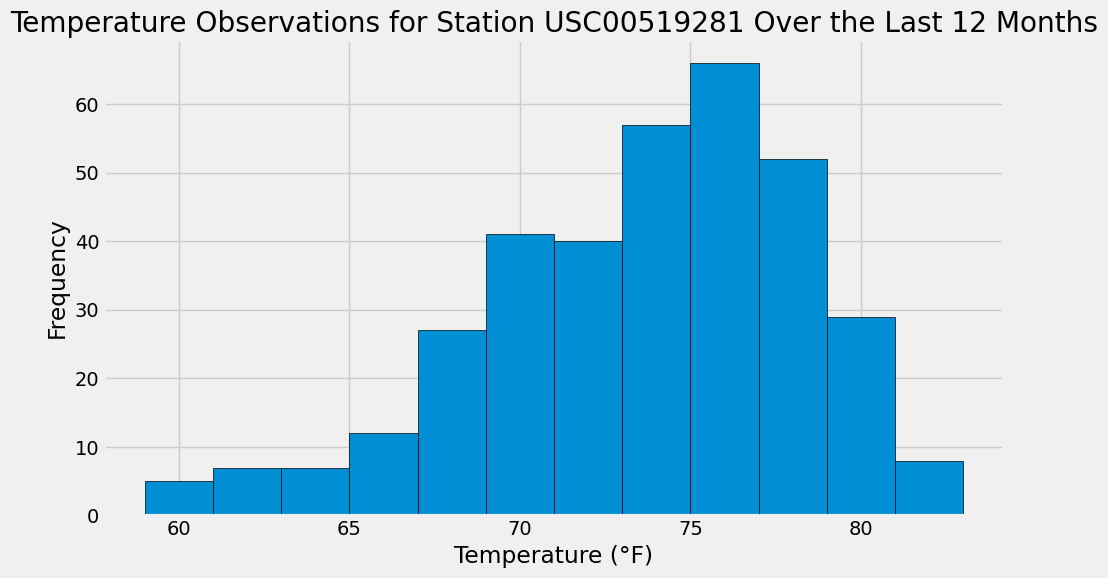

In [76]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.date, Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)
# Save the query results as a Pandas DataFrame and set the column names.
temperature_df = pd.DataFrame(temperature_data, columns=["date", "tobs"])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station} Over the Last 12 Months')
plt.tight_layout()
plt.show()

# Close Session

In [77]:
# Close Session
session.close()
